<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/Tutorial_I_RCWA_and_Physical_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script provides a simple example for how to use the RCWA solver and simulate a field. We also show how to explicitly call for the gradients. 

This type of implementation is done in the backend of the rcwa_layer calls but it is certainly useful to know how to implement your own version for exploring new studies and shape spaces.

To avoid writing boilerplate code for standard cell features, the RCWA_layer (reviewed in this tutorial) lets you immedietly optimize precoded cell types in batch (e.g. a collection of NxM cells). As it inherits from the Keras architecture, it can be immediently linked to standard Keras Deep Learning modules.



# Clone D$\flat$ Repository and Install

D$\flat$ is a relatively large package as it contains raw data files for nanocell libraries and pre-trained neural models. It may take a few minutes to download

In [ ]:
!git lfs install
!git clone -b Modify_Repo https://github.com/DeanHazineh/DFlat

%cd /content/DFlat
!python setup.py develop

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 2953, done.
remote: Counting objects: 100% (972/972), done.
remote: Compressing objects: 100% (654/654), done.
remote: Total 2953 (delta 398), reused 822 (delta 303), pack-reused 1981
Receiving objects: 100% (2953/2953), 757.83 MiB | 24.94 MiB/s, done.
Resolving deltas: 100% (978/978), done.
Updating files: 100% (191/191), done.
/content/DFlat
running develop
running egg_info
creating DFlat.egg-info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
writing manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.8/dist-packages/DFlat.egg-link (li

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 KB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
  Created wheel for gdspy: filename=gdspy-1.6.12-cp38-cp38-linux_x86_64.whl size=597229 sha256=da627ebaae6936b8704501a51cc3365ccc7c33d1782fcd9957e883bcb2cb0b11
  Stored in directory: /root/.cache/pip/wheels/03/ed/d5/f89483da9ebf5b67e58ba967e19132ae7703a6409727790445
Successfully built gdspy
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12


# Run a RCWA Simulation

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import dflat.physical_optical_layer as df_physical
import dflat.data_structure as df_struct

To run a simulation, first we need to create the RCWA solver parameters object. Here, you specify the material used and the params object will internally grab and store the broadband, complex refractive index into its class attributes. 

You can specify a material from the list below or you can pass in a complex, float instead. 

In [ ]:
df_physical.list_materials()

['TiO2', 'SiO2', 'Vacuum', 'Si', 'Si3N4']

In [ ]:
wavelength_set_m = np.arange(400e-9, 750e-9, 10e-9)
fourier_modes = 7
rcwa_parameters = df_struct.rcwa_params(
    {
        "wavelength_set_m": wavelength_set_m,
        "thetas": [0.0 for i in wavelength_set_m],
        "phis": [0.0 for i in wavelength_set_m],
        "pte": [1.0 for i in wavelength_set_m],
        "ptm": [1.0 for i in wavelength_set_m],
        "pixelsX": 1,
        "pixelsY": 1,
        "PQ": [fourier_modes, fourier_modes],
        "Lx": 350e-9,
        "Ly": 350e-9,
        "L": [650.0e-9],
        "Lay_mat": ["Vacuum"],
        "material_dielectric": "TiO2",
        "er1": "SiO2",
        "er2": "Vacuum",
        "Nx": 512,
        "Ny": 512
    }
)

Now, let us write our own solver function from scratch. The goal is that we may pass in the rcwa_parameters and a binary_mask representing the nanostructure on the cell. This function can then inject the correct permittivity values (stored in rcwa_parameters as key "erd" for the specified material_dielectric) and call the rcwa_solver.  

In this example I am only simulating a single layer but I have written the function with an open mind to enable multi-layer with minimal modifications (it is a good practice to do so!)

In [ ]:
def rcwa_calc_field(rcwa_parameters, binary_mask):
    ###
    batchSize = rcwa_parameters["batchSize"]
    pixelsX = rcwa_parameters["pixelsX"]
    pixelsY = rcwa_parameters["pixelsY"]
    Nx = rcwa_parameters["Nx"]
    Ny = rcwa_parameters["Ny"]
    Nlay = rcwa_parameters["Nlay"]
    dtype = rcwa_parameters["dtype"]
    cdtype = rcwa_parameters["cdtype"]

    materials_shape = (batchSize, pixelsX, pixelsY, Nlay, Nx, Ny)
    PQ_zero = tf.math.reduce_prod(rcwa_parameters["PQ"]) // 2
    lay_eps_list = rcwa_parameters["lay_eps_list"]

    # Assemble cell
    binary = tf.complex(tf.cast(binary_mask, dtype=dtype), tf.cast(0.0, dtype=dtype))
    UR = rcwa_parameters["urd"] * tf.ones(materials_shape, dtype=cdtype)
    ER_list = []
    for i, lay_eps in enumerate(lay_eps_list):
        ER_list.append(lay_eps_list[i] + (rcwa_parameters["erd"] - lay_eps_list[i]) * binary[i])
    ER = tf.concat(values=ER_list, axis=3)

    ## Call Simulation
    outputs = df_physical.simulate(ER, UR, rcwa_parameters)
    tx = outputs["tx"][:, :, :, PQ_zero, 0] # Get the zero order field by PQ_zero
    ty = outputs["ty"][:, :, :, PQ_zero, 0] 
    field = tf.expand_dims(tf.transpose(tf.stack((tx, ty))), 0)

    return field

Now let us define a simple cell structure and ideally assemble the structure in a way that is differentiable. Then we can obtain gradients later. 

In [ ]:
def make_nanofin_mask(rcwa_parameters, finx, finy):
  # Create a grid
  Nx, Ny = rcwa_parameters["Nx"], rcwa_parameters["Ny"]
  Lx, Ly = rcwa_parameters["Lx"], rcwa_parameters["Ly"]
  xx, yy = np.meshgrid(np.linspace(-Lx/2, Lx/2, Nx), np.linspace(-Ly/2, Ly/2, Ny))

  power_exp = 50
  sigmoid_coeff=1000
  mask = 1 - tf.math.abs(xx * 2 / finx) ** power_exp - tf.math.abs(yy * 2 / finy) ** power_exp
  mask = tf.math.sigmoid(sigmoid_coeff * mask)

  return tf.expand_dims(mask,0)

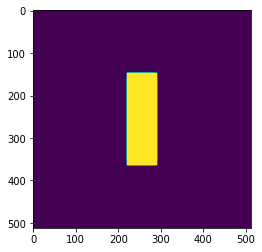

In [ ]:
out = make_nanofin_mask(rcwa_parameters, 50e-9, 150e-9)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(out[0])

Now let us combine our cell assembly function with our solve function to compute the fields.

In [ ]:
binary_mask = make_nanofin_mask(rcwa_parameters, 50e-9, 150e-9)
transmitted_field = rcwa_calc_field(rcwa_parameters, binary_mask)
transmitted_field = tf.squeeze(transmitted_field)

It is wise to compute the reference field (simulate a cell with no structure). You can do this just like you have already done above but many common routines are built-in D$\flat$ as they are used for more advanced architectures like the RCWA Layer. 

In [ ]:
ref_field = tf.squeeze(df_physical.core.batch_solver.compute_ref_field(rcwa_parameters))

relTransmission = np.abs(transmitted_field.numpy())**2/np.abs(ref_field.numpy())**2
relPhase_delay_wrapped = np.angle(np.exp(1j*(np.angle(transmitted_field.numpy()) - np.angle(ref_field.numpy()))))

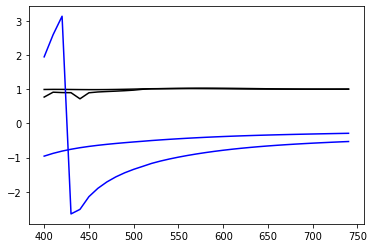

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wavelength_set_m *1e9, relTransmission, 'k-')
ax.plot(wavelength_set_m *1e9,relPhase_delay_wrapped, 'b-')

# Call gradients 

For this example, let us just use an objective function arbitrarily defined according to the sum of transmission. This is not particularly practical for a dieletric nano-cell but you can still compute the gradients.

To do this, we use the tf gradientTape method.

Note that when we do this in RCWA_latent_layer, we utilize the principle of reparameterization to enforce constraints and keep the gradients stable. This is not done below to keep the tutorial simple but its important to remember. 


In [ ]:
finx = tf.Variable(60e-9, trainable=True)
finy = tf.Variable(160e-9, trainable=True)
Lx, Ly = rcwa_parameters["Lx"], rcwa_parameters["Ly"]

with tf.GradientTape() as tape:
  # Calculation
  binary_mask = make_nanofin_mask(rcwa_parameters, finx, finy)
  transmitted_field = rcwa_calc_field(rcwa_parameters, binary_mask)
  transmitted_field = tf.squeeze(transmitted_field)
   
  # objective function
  energy = tf.math.reduce_sum(tf.math.abs(transmitted_field)**2)

# Get gradients
gradients = tape.gradient(energy, [finx, finy])

In [ ]:
print(gradients)

[<tf.Tensor: shape=(), dtype=float32, numpy=2.6016016e-26>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0891512e-27>]


# Using the RCWA_Layer

Part of the work and utility of D$\flat$ is enabling an easy way to test old optical front-ends with new computational backends for computational imaging researchers. Once we discover a useful set of structures or optical metasurface, we don't want to have to carry around the code ourselves to use it again later. 

The RCWA_Layer is a place where useful metasurface cell representations are stored and packaged. A call to the RCWA_layer will convert the input parameter to the output, relative fields. 

The functions to take the input parameters to cell binraries, assemble the physical structure, and pass it RCWA is packaged on the back-end for pre-coded cell types. First, let us see what types we already have in D$\flat$.

More will be added in the future but if interested, one should look at the source code for how this works. It is wise to take the make_mask function from above and just directly write/integrate it in the RCWA_Layer from the start. It saves the time of rewritting uneccesary functions. 

In [ ]:
# Initialize RCWA_Parameters and indicate we will want 3x3 array of cells
fourier_modes = 7
rcwa_parameters = df_struct.rcwa_params(
    {
        "wavelength_set_m": wavelength_set_m,
        "thetas": [0.0 for i in wavelength_set_m],
        "phis": [0.0 for i in wavelength_set_m],
        "pte": [1.0 for i in wavelength_set_m],
        "ptm": [1.0 for i in wavelength_set_m],
        "pixelsX": 3,
        "pixelsY": 3,
        "PQ": [fourier_modes, fourier_modes],
        "Lx": 350e-9,
        "Ly": 350e-9,
        "L": [650.0e-9],
        "Lay_mat": ["Vacuum"],
        "material_dielectric": "TiO2",
        "er1": "SiO2",
        "er2": "Vacuum",
        "Nx": 512,
        "Ny": 512
    }
)

# Print the list of pre-coded cell parameterizations
df_physical.list_cell_parameterizations()

['rectangular_resonators', 'coupled_rectangular_resonators', 'cylindrical_nanoposts']


The layer class is initialized by passing in the name of the cell binary function. The three above all assemble a dieletric on a single layer and you may index which of the layers it is placed on via the feature_layer=int.

The shape vector size is function specific-- a cylinder only needs the radius for each cell while the nanofins need two parameters, one for length and width. You can remind yourself of the size by printing the class attribute shape_vect_size. It is always of the form (D1, PixelsX, PixelsY, D2) where D is the number of parameters to represent that cell type in our back-end assembly function. This representation may change in the future in the backend but the code and functions will be preserved.

In [ ]:
rcwa_layer = df_physical.RCWA_Layer(rcwa_parameters, "rectangular_resonators", feature_layer=0)
input_size = rcwa_layer.shape_vect_size
print(input_size)

ListWrapper([2, 3, 3, 1])


A very important note is that the input parameter vector is always a normalized quantity with values between $[0, 1]$. This corresponds to a minimum and maximum span (related to a fraction of the cell size). 

The reason for this lies in the fact that D$\flat$ is designed for inverse-design and optimization. If we want to add constraints to the optimization and gradient-descent scheme, it is signficantly easier to do this when we deal with normalized quantities. 

In [ ]:
vec = np.random.random(input_size)
transmittance, phase = rcwa_layer(vec)
print(transmittance.shape, phase.shape)

(35, 2, 3, 3) (35, 2, 3, 3)


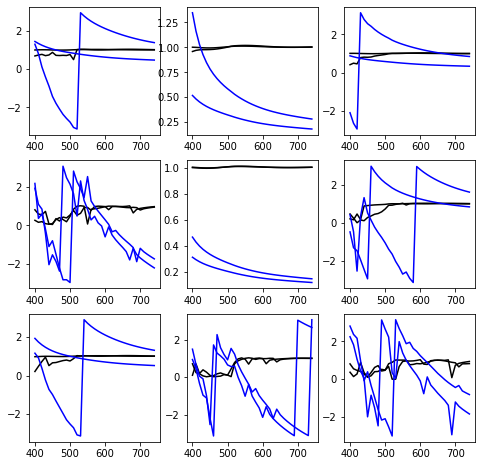

In [ ]:
import dflat.plot_utilities as df_plt # I prefer this code wrapper for making subplots 

pixelsX, pixelsY = rcwa_parameters["pixelsX"], rcwa_parameters["pixelsY"]
fig = plt.figure(figsize=(8,8))
ax = df_plt.addAxis(fig,pixelsY, pixelsX)
iter=0
for r in range(pixelsX):
  for c in range(pixelsY):
    ax[iter].plot(wavelength_set_m*1e9, transmittance[:,:,r,c].numpy()**2, 'k-')
    ax[iter].plot(wavelength_set_m*1e9, np.angle(np.exp(1j*phase[:,:,r,c].numpy())), 'b-')
    iter+=1
